# Notebook to define binary phenotypes
-	Group 1: Individuals with ≥1 additional OPRM1-interacting drug exposure within 45 days following the initial morphine/codeine exposure.
-	Group 2: Individuals with ≥2 additional OPRM1-interacting drug exposures within 90 days.
-	Group 3: Individuals with ≥3 additional OPRM1-interacting drug exposures within 180 days.
-	Group 4: Individuals with ≥4 additional OPRM1-interacting drug exposures within 365 days. 
-	Group 5: Individuals who met the criteria for any of Groups 1–4. 
Control Group: Individuals with 1 morphine or codeine exposure (or 2 within the same drug era), and 0 exposures to any other OPRM1-interacting drugs within 365 days following the initial exposure. 


## Obtain eids and start and end era per drug

Using omop drug era database

In [27]:
import pyspark
import dxpy
import dxdata
from pyspark.sql import functions as F

import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns

Import to current directory:
- mappings/drug_era/drug_era_atc.tsv
- src/project_permed

First obtain the drug id with drug_era_atc.tsv table and the atc_dict.py to obtain the ATC of each drug.

In [ ]:
# Load the table
df_ATC = pd.read_csv("drug_era_atc.tsv", sep="\t")

# Convert concept_name and drugs_to_filter to lowercase for case-insensitive filtering
df_ATC["concept_name_lower"] = df_ATC["concept_name"].str.lower()

# List of drugs to filter
drugs_to_filter = [
    "Loperamide",
    "Morphine",
    "Methadone",
    "Fentanyl",
    "Sufentanil",
    "3-Methylfentanyl",
    "3-Methylthiofentanyl",
    "Alfentanil",
    "Alvimopan",
    "Amisulpride",
    "Amitriptyline",
    "Anileridine",
    "Aripiprazole",
    "Buprenorphine",
    "Butorphanol",
    "Butyrfentanyl",
    "Cannabidiol",
    "Carfentanil",
    "Codeine",
    "Dextromethorphan",
    "Dextropropoxyphene",
    "Dezocine",
    "Diamorphine",
    "Dihydromorphine",
    "Dimethylthiambutene",
    "Diphenoxylate",
    "Diprenorphine",
    "Eluxadoline",
    "Epicept Np-1",
    "Ethylmorphine",
    "Etorphine",
    "Hydrocodone",
    "Hydromorphone",
    "Ketamine",
    "Ketobemidone",
    "Li-301",
    "Levacetylmethadol",
    "Levallorphan",
    "Levorphanol",
    "Loxicodegol",
    "Cannabis",
    "Meperidine",
    "Metenkefalin",
    "Methadyl Acetate",
    "Methylnaltrexone",
    "Morphine Glucuronide",
    "Nabiximols",
    "Nalbuphine",
    "Naldemedine",
    "Nalmefene",
    "Naloxegol",
    "Naloxone",
    "Naltrexone",
    "Oliceridine",
    "Ondansetron",
    "Opium",
    "Oxycodone",
    "Oxymorphone",
    "Pentazocine",
    "Pentoxyverine",
    "Pholcodine",
    "Remifentanil",
    "Samidorphan",
    "Tapentadol",
    "Tianeptine",
    "Tramadol",
    "Trimebutine",
    "V1003",
]
drugs_to_filter_lower = {drug.lower() for drug in drugs_to_filter}

# Filter rows where the lowercase drug name is in the lowercase list of drugs to filter
filtered_df_ATC = df_ATC[df_ATC["concept_name"].isin(drugs_to_filter_lower)]

# Identify drugs that do not appear in the dataframe
missing_drugs = drugs_to_filter_lower - set(df_ATC["concept_name_lower"])

# Print a message if there are missing drugs
if missing_drugs:
    print(
        f"The following drugs were not found in the dataset: {', '.join(missing_drugs)}"
    )

# Drop the temporary lowercase column to keep the original dataframe clean
df_ATC.drop(columns=["concept_name_lower"], inplace=True)

# Select the required columns and rename _c13 to ATC
filtered_df_ATC = filtered_df_ATC[
    [
        "drug_concept_id",
        "concept_name",
        "domain_id",
        "concept_class_id",
        "concept_code",
        "valid_start_date",
        "valid_end_date",
        "invalid_reason",
        "_c13",
    ]
]

# Rename the _c13 column to ATC
filtered_df_ATC.rename(columns={"_c13": "ATC"}, inplace=True)

display(filtered_df_ATC)

The following drugs were not found in the dataset: dihydromorphine, levorphanol, oliceridine, nalbuphine, diamorphine, cannabis, tianeptine, metenkefalin, morphine glucuronide, ethylmorphine, levallorphan, anileridine, v1003, sufentanil, trimebutine, alvimopan, dimethylthiambutene, levacetylmethadol, li-301, eluxadoline, loxicodegol, 3-methylthiofentanyl, diprenorphine, epicept np-1, opium, dextropropoxyphene, methylnaltrexone, carfentanil, dezocine, nabiximols, ketobemidone, remifentanil, samidorphan, methadyl acetate, naldemedine, butorphanol, oxymorphone, 3-methylfentanyl, etorphine, butyrfentanyl, pentoxyverine, hydrocodone


,drug_concept_id,concept_name,domain_id,concept_class_id,concept_code,valid_start_date,valid_end_date,invalid_reason,ATC
52,930916,diphenoxylate,Drug,Ingredient,3500,1970-01-01,2099-12-31,NaN,A07DA01
64,1154029,fentanyl,Drug,Ingredient,4337,1970-01-01,2099-12-31,NaN,N01AH01
65,1154029,fentanyl,Drug,Ingredient,4337,1970-01-01,2099-12-31,NaN,N02AB03
99,1102527,meperidine,Drug,Ingredient,6754,1970-01-01,2099-12-31,NaN,N02AB02
101,1103640,methadone,Drug,Ingredient,6813,1970-01-01,2099-12-31,NaN,N07BC02
271,757688,aripiprazole,Drug,Ingredient,89013,1970-01-01,2099-12-31,NaN,N05AX12
322,45774613,naloxegol,Drug,Ingredient,1551777,2014-12-01,2099-12-31,NaN,A06AH03
334,710062,amitriptyline,Drug,Ingredient,704,1970-01-01,2099-12-31,NaN,N06AA09
418,785649,ketamine,Drug,Ingredient,6130,1970-01-01,2099-12-31,NaN,N01AX03
421,991876,loperamide,Drug,Ingredient,6468,1970-01-01,2099-12-31,NaN,A07DA03


In [3]:
# Import the ATC dictionaries from atc_dict.py
from atc_dict import atc_1st_level, atc_2nd_level

# Map first level ATC codes
filtered_df_ATC["ATC_First_Level"] = filtered_df_ATC["ATC"].apply(
    lambda x: x[0] if isinstance(x, str) else None
)
filtered_df_ATC["ATC_Second_Level"] = filtered_df_ATC["ATC"].apply(
    lambda x: x[:3] if isinstance(x, str) else None
)

# Map the names of the first and second level ATC categories using the imported dictionaries
filtered_df_ATC["First_Level_Name"] = filtered_df_ATC["ATC_First_Level"].map(
    atc_1st_level
)
filtered_df_ATC["Second_Level_Name"] = filtered_df_ATC["ATC_Second_Level"].map(
    lambda x: atc_2nd_level.get(x[0], {}).get(x, "Unknown")
)

filtered_df_ATC

,drug_concept_id,concept_name,domain_id,concept_class_id,concept_code,valid_start_date,valid_end_date,invalid_reason,ATC,ATC_First_Level,ATC_Second_Level,First_Level_Name,Second_Level_Name
52,930916,diphenoxylate,Drug,Ingredient,3500,1970-01-01,2099-12-31,NaN,A07DA01,A,A07,Alimentary Tract and Metabolism,"Antidiarrheals, Intestinal Anti-inflammatory/A..."
64,1154029,fentanyl,Drug,Ingredient,4337,1970-01-01,2099-12-31,NaN,N01AH01,N,N01,Nervous System,Anesthetics
65,1154029,fentanyl,Drug,Ingredient,4337,1970-01-01,2099-12-31,NaN,N02AB03,N,N02,Nervous System,Analgesics
99,1102527,meperidine,Drug,Ingredient,6754,1970-01-01,2099-12-31,NaN,N02AB02,N,N02,Nervous System,Analgesics
101,1103640,methadone,Drug,Ingredient,6813,1970-01-01,2099-12-31,NaN,N07BC02,N,N07,Nervous System,Other Nervous System Drugs
271,757688,aripiprazole,Drug,Ingredient,89013,1970-01-01,2099-12-31,NaN,N05AX12,N,N05,Nervous System,Psycholeptics
322,45774613,naloxegol,Drug,Ingredient,1551777,2014-12-01,2099-12-31,NaN,A06AH03,A,A06,Alimentary Tract and Metabolism,Drugs for Constipation
334,710062,amitriptyline,Drug,Ingredient,704,1970-01-01,2099-12-31,NaN,N06AA09,N,N06,Nervous System,Psychoanaleptics
418,785649,ketamine,Drug,Ingredient,6130,1970-01-01,2099-12-31,NaN,N01AX03,N,N01,Nervous System,Anesthetics
421,991876,loperamide,Drug,Ingredient,6468,1970-01-01,2099-12-31,NaN,A07DA03,A,A07,Alimentary Tract and Metabolism,"Antidiarrheals, Intestinal Anti-inflammatory/A..."


In [4]:
# Save the filtered table to a new file
filtered_df_ATC.to_csv("filtered_drug_atc.tsv", sep="\t", index=False)

Now we can obtain the omop data bases from UK Biobank and filter for the drugs ids of interest

In [5]:
sc = pyspark.SparkContext()
spark = pyspark.sql.SparkSession(sc)

dispensed_database_name = dxpy.find_one_data_object(
    classname="database", name="app*", folder="/", name_mode="glob", describe=True
)["describe"]["name"]
dispensed_dataset_id = dxpy.find_one_data_object(
    typename="Dataset", name="app*.dataset", folder="/", name_mode="glob"
)["id"]

spark.sql("USE " + dispensed_database_name)

dataset = dxdata.load_dataset(id=dispensed_dataset_id)

In [6]:
# Init pyspark and load dataframe
# Load the 'omop_drug_era' table
omop_drug_era = "omop_drug_era"

# Load table
drug_era = dataset[omop_drug_era]

# Extract all field names from the table
field_names_era = [f.name for f in drug_era.fields]

# Retrieve the fields
df_era = drug_era.retrieve_fields(names=field_names_era, engine=dxdata.connect())

print(df_era.columns)

print(f"Number of entries era {df_era.count()}")
df_era.drop("eid").show(3, truncate=False)

/opt/conda/lib/python3.11/site-packages/thrift/transport/TSSLSocket.py:53: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated
  self._context = ssl.SSLContext(ssl_version)


['eid', 'drug_era_id', 'drug_concept_id', 'drug_era_start_date', 'drug_era_end_date', 'drug_exposure_count', 'gap_days']
Number of entries era 19959413
+-------------+---------------+-------------------+-----------------+-------------------+--------+
|drug_era_id  |drug_concept_id|drug_era_start_date|drug_era_end_date|drug_exposure_count|gap_days|
+-------------+---------------+-------------------+-----------------+-------------------+--------+
|1236950609195|19005129       |12/05/2014         |10/06/2014       |1                  |0       |
|798863919105 |743670         |30/03/2011         |02/09/2011       |5                  |12      |
|721554547993 |19008994       |12/10/2010         |07/11/2010       |1                  |0       |
+-------------+---------------+-------------------+-----------------+-------------------+--------+
only showing top 3 rows



In [7]:
# Load the `filtered_drug_atc.tsv` file as a Pandas DataFrame
drug_mapping_df = pd.read_csv("filtered_drug_atc.tsv", sep="\t")
# Extract `drug_concept_id` values as a list
drug_concept_ids = drug_mapping_df["drug_concept_id"].dropna().unique().tolist()
drug_concept_ids

[930916,
 1154029,
 1102527,
 1103640,
 757688,
 45774613,
 710062,
 785649,
 991876,
 1714319,
 1000560,
 19014158,
 19024213,
 19026459,
 1133201,
 1103314,
 19057607,
 19059528,
 1114220,
 1130585,
 1510417,
 1201620,
 1119510,
 1126658,
 1110410,
 1124957]

In [ ]:
# Filter the OMOP dataset for relevant drug_concept_id
filtered_df_era = df_era.filter(F.col("drug_concept_id").isin(drug_concept_ids))
# Format date columns
filtered_df_era = filtered_df_era.withColumn(
    "drug_era_start_date", F.to_date(F.col("drug_era_start_date"), "dd/MM/yyyy")
).withColumn("drug_era_end_date", F.to_date(F.col("drug_era_end_date"), "dd/MM/yyyy"))

# Remove duplicates in drug_mapping_df based on 'drug_concept_id' and 'concept_name'
drug_mapping_df = drug_mapping_df.drop_duplicates(
    subset=["drug_concept_id", "concept_name"]
)

# Convert Pandas DataFrame (drug_mapping_df) to Spark DataFrame
drug_mapping_spark_df = spark.createDataFrame(drug_mapping_df)

# Ensure "drug_concept_id" is the same type in both DataFrames
filtered_df_era = filtered_df_era.withColumn(
    "drug_concept_id", F.col("drug_concept_id").cast("int")
)
drug_mapping_spark_df = drug_mapping_spark_df.withColumn(
    "drug_concept_id", F.col("drug_concept_id").cast("int")
)

# Perform the join with drug_mapping_df on "drug_concept_id"
filtered_df_era = filtered_df_era.join(
    drug_mapping_spark_df.select(
        "drug_concept_id", "concept_name"
    ),  # Select only necessary columns
    on="drug_concept_id",
    how="left",
)

# Rename the 'concept_name' column to 'drug'
filtered_df_era = filtered_df_era.withColumnRenamed("concept_name", "drug")

# Sort by "drug_era_start_date"
filtered_df_era = filtered_df_era.orderBy("drug_era_start_date")

# Show the result of the filter
filtered_df_era.drop("eid").show(truncate=False)
filtered_df_era.count()

+---------------+-------------+-------------------+-----------------+-------------------+--------+-------------+
|drug_concept_id|drug_era_id  |drug_era_start_date|drug_era_end_date|drug_exposure_count|gap_days|drug         |
+---------------+-------------+-------------------+-----------------+-------------------+--------+-------------+
|991876         |652835088928 |1990-01-01         |1990-01-30       |1                  |0       |loperamide   |
|1201620        |1597727924666|1990-01-01         |1990-01-30       |1                  |0       |codeine      |
|991876         |1486058743225|1990-01-01         |1990-01-06       |1                  |0       |loperamide   |
|991876         |1314260071294|1990-01-01         |1990-01-12       |1                  |0       |loperamide   |
|1201620        |601295454371 |1990-01-02         |1990-01-31       |1                  |0       |codeine      |
|1201620        |1262720440376|1990-01-02         |1990-01-31       |1                  |0      

869262

In [9]:
# Convert the filtered Spark DataFrame to a Pandas DataFrame
pandas_filtered_df_era = filtered_df_era.toPandas()

In [ ]:
# Filter for rows with "morphine" or "codeine" in the "drug" column (case-insensitive)
filtered_df_era_morphine_codeine = pandas_filtered_df_era[
    pandas_filtered_df_era["drug"].str.contains(
        "morphine|codeine", case=False, na=False
    )
]

# Show the result of the filter
display(filtered_df_era_morphine_codeine.drop("eid", axis=1))

,drug_concept_id,drug_era_id,drug_era_start_date,drug_era_end_date,drug_exposure_count,gap_days,drug
0,1201620,1597727924666,1990-01-01,1990-01-30,1,0,codeine
4,1201620,601295454371,1990-01-02,1990-01-31,1,0,codeine
5,1201620,1262720440376,1990-01-02,1990-01-31,1,0,codeine
6,1201620,128849029717,1990-01-03,1990-02-01,1,0,codeine
7,1201620,1434519131532,1990-01-03,1990-02-01,1,0,codeine
...,...,...,...,...,...,...,...
869249,1201620,558345805315,2017-09-20,2017-10-19,1,0,codeine
869250,1201620,601295449619,2017-09-20,2017-10-19,1,0,codeine
869251,1201620,781684096456,2017-09-20,2017-10-19,1,0,codeine
869252,1201620,128849082881,2017-09-20,2017-10-19,1,0,codeine


In [ ]:
# Convert the filtered Spark DataFrame to a Pandas DataFrame
filtered_df_era_morphine_codeine_grouped = (
    filtered_df_era_morphine_codeine.groupby("eid")
    .agg(
        num_drug_era_id=("drug_era_id", "nunique"),
        drugs=("drug", list),
        start_dates=("drug_era_start_date", list),
        end_dates=("drug_era_end_date", list),
        exposure_counts=("drug_exposure_count", list),
        gap_days=("gap_days", list),
    )
    .reset_index()
)
display(filtered_df_era_morphine_codeine_grouped.drop("eid", axis=1))

,num_drug_era_id,drugs,start_dates,end_dates,exposure_counts,gap_days
0,1,[codeine],[2004-12-20],[2004-12-28],[1],[0]
1,2,"[codeine, codeine]","[2012-05-24, 2013-03-22]","[2012-06-22, 2013-04-20]","[1, 1]","[0, 0]"
2,3,"[codeine, codeine, codeine]","[2011-05-18, 2011-09-27, 2013-06-27]","[2011-08-06, 2011-10-30, 2013-07-05]","[6, 1, 1]","[0, 0, 0]"
3,6,"[codeine, codeine, codeine, codeine, codeine, ...","[2008-06-03, 2008-09-18, 2008-12-23, 2009-03-1...","[2008-07-02, 2008-10-18, 2009-01-21, 2009-04-1...","[1, 2, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0]"
4,3,"[codeine, codeine, codeine]","[2008-06-09, 2012-03-05, 2014-11-17]","[2008-06-13, 2012-04-03, 2014-12-16]","[1, 1, 1]","[0, 0, 0]"
...,...,...,...,...,...,...
103444,7,"[codeine, codeine, codeine, codeine, codeine, ...","[1999-04-01, 2001-12-07, 2002-12-11, 2010-01-2...","[1999-04-30, 2002-01-22, 2003-01-09, 2010-02-1...","[1, 2, 1, 1, 2, 1, 1]","[0, 0, 0, 0, 26, 0, 0]"
103445,10,"[codeine, codeine, codeine, codeine, codeine, ...","[2010-03-22, 2010-09-27, 2011-02-08, 2012-02-0...","[2010-07-17, 2010-10-26, 2011-06-17, 2012-03-0...","[4, 1, 3, 1, 1, 1, 1, 1, 1, 1]","[21, 0, 42, 0, 0, 0, 0, 0, 0, 0]"
103446,5,"[codeine, codeine, codeine, codeine, codeine]","[2000-06-06, 2006-01-10, 2006-05-16, 2011-06-2...","[2000-07-05, 2006-02-08, 2006-06-14, 2011-07-2...","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]"
103447,8,"[codeine, codeine, codeine, codeine, codeine, ...","[2001-08-13, 2005-04-25, 2008-07-25, 2009-03-0...","[2001-09-11, 2005-05-24, 2008-12-31, 2009-04-0...","[1, 1, 4, 1, 2, 11, 2, 1]","[0, 0, 46, 0, 24, 31, 12, 0]"


In [ ]:
# Total exposures per participant
# Convert all elements in 'exposure_counts' lists to integers
filtered_df_era_morphine_codeine_grouped["exposure_counts"] = (
    filtered_df_era_morphine_codeine_grouped["exposure_counts"].apply(
        lambda x: [int(i) for i in x]  # Ensures all elements are integers
    )
)

# Compute total_exposure_counts
filtered_df_era_morphine_codeine_grouped["total_exposure_counts"] = (
    filtered_df_era_morphine_codeine_grouped["exposure_counts"].apply(sum)
)

In [13]:
display(filtered_df_era_morphine_codeine_grouped.drop("eid", axis=1))

,num_drug_era_id,drugs,start_dates,end_dates,exposure_counts,gap_days,total_exposure_counts
0,1,[codeine],[2004-12-20],[2004-12-28],[1],[0],1
1,2,"[codeine, codeine]","[2012-05-24, 2013-03-22]","[2012-06-22, 2013-04-20]","[1, 1]","[0, 0]",2
2,3,"[codeine, codeine, codeine]","[2011-05-18, 2011-09-27, 2013-06-27]","[2011-08-06, 2011-10-30, 2013-07-05]","[6, 1, 1]","[0, 0, 0]",8
3,6,"[codeine, codeine, codeine, codeine, codeine, ...","[2008-06-03, 2008-09-18, 2008-12-23, 2009-03-1...","[2008-07-02, 2008-10-18, 2009-01-21, 2009-04-1...","[1, 2, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0]",7
4,3,"[codeine, codeine, codeine]","[2008-06-09, 2012-03-05, 2014-11-17]","[2008-06-13, 2012-04-03, 2014-12-16]","[1, 1, 1]","[0, 0, 0]",3
...,...,...,...,...,...,...,...
103444,7,"[codeine, codeine, codeine, codeine, codeine, ...","[1999-04-01, 2001-12-07, 2002-12-11, 2010-01-2...","[1999-04-30, 2002-01-22, 2003-01-09, 2010-02-1...","[1, 2, 1, 1, 2, 1, 1]","[0, 0, 0, 0, 26, 0, 0]",9
103445,10,"[codeine, codeine, codeine, codeine, codeine, ...","[2010-03-22, 2010-09-27, 2011-02-08, 2012-02-0...","[2010-07-17, 2010-10-26, 2011-06-17, 2012-03-0...","[4, 1, 3, 1, 1, 1, 1, 1, 1, 1]","[21, 0, 42, 0, 0, 0, 0, 0, 0, 0]",15
103446,5,"[codeine, codeine, codeine, codeine, codeine]","[2000-06-06, 2006-01-10, 2006-05-16, 2011-06-2...","[2000-07-05, 2006-02-08, 2006-06-14, 2011-07-2...","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]",5
103447,8,"[codeine, codeine, codeine, codeine, codeine, ...","[2001-08-13, 2005-04-25, 2008-07-25, 2009-03-0...","[2001-09-11, 2005-05-24, 2008-12-31, 2009-04-0...","[1, 1, 4, 1, 2, 11, 2, 1]","[0, 0, 46, 0, 24, 31, 12, 0]",23


In [ ]:
# Filter for rows with 1 or 2 total exposures within 1 drug era
single_exposure_df = filtered_df_era_morphine_codeine_grouped[
    (filtered_df_era_morphine_codeine_grouped["total_exposure_counts"] <= 2)
    & (filtered_df_era_morphine_codeine_grouped["num_drug_era_id"] == 1)
]

# Count the number of single-exposure rows
num_single_exposures = single_exposure_df.shape[0]
print(
    f"Number of rows with 1 or 2 total exposures within 1 drug era: {num_single_exposures}"
)
# Display the result without 'eid'
display(single_exposure_df.drop("eid", axis=1))

Number of rows with 1 or 2 total exposures within 1 drug era: 40061


,num_drug_era_id,drugs,start_dates,end_dates,exposure_counts,gap_days,total_exposure_counts
0,1,[codeine],[2004-12-20],[2004-12-28],[1],[0],1
6,1,[morphine],[2013-02-06],[2013-03-12],[2],[0],2
11,1,[codeine],[2017-02-17],[2017-04-04],[2],[0],2
12,1,[codeine],[2007-05-30],[2007-06-24],[1],[0],1
13,1,[codeine],[2001-04-09],[2001-05-08],[1],[0],1
...,...,...,...,...,...,...,...
103440,1,[codeine],[2004-12-31],[2005-01-14],[1],[0],1
103441,1,[codeine],[2006-10-17],[2006-11-15],[1],[0],1
103442,1,[codeine],[2014-03-05],[2014-04-03],[1],[0],1
103443,1,[codeine],[2012-05-25],[2012-06-23],[1],[0],1


In [ ]:
other_drugs_df = (
    pandas_filtered_df_era.groupby("eid")
    .agg(drugs=("drug", list), start_dates=("drug_era_start_date", list))
    .reset_index()
)

# Filter using only relevant EIDs
eids_to_keep = single_exposure_df["eid"].unique()
other_drugs_df = other_drugs_df[other_drugs_df["eid"].isin(eids_to_keep)]

# Display the filtered results
display(other_drugs_df.drop("eid", axis=1))

,drugs,start_dates
2,[codeine],[2004-12-20]
9,"[morphine, tramadol]","[2013-02-06, 2013-02-11]"
14,[codeine],[2017-02-17]
16,[codeine],[2007-05-30]
17,[codeine],[2001-04-09]
...,...,...
124537,"[codeine, amitriptyline]","[2004-12-31, 2015-09-24]"
124538,[codeine],[2006-10-17]
124539,[codeine],[2014-03-05]
124540,[codeine],[2012-05-25]


In [ ]:
# Drugs to exclude
excluded_drugs = {"codeine", "morphine"}


# Function to get count and list of other drugs within a window
def count_and_list_other_drugs(row, window_days):
    excluded_drugs = {"codeine", "morphine"}

    # Other drugs and their start dates
    other_drugs = [
        (drug, pd.to_datetime(date))
        for drug, date in zip(row["drugs"], row["start_dates"])
        if drug not in excluded_drugs
    ]

    # Codeine/morphine start dates
    cm_start_dates = [
        pd.to_datetime(date)
        for drug, date in zip(row["drugs"], row["start_dates"])
        if drug in excluded_drugs
    ]

    # Find matching drugs
    included_other_drugs = []
    for cm_date in cm_start_dates:
        included_other_drugs.extend(
            [
                drug
                for drug, drug_date in other_drugs
                if 0 < (drug_date - cm_date).days <= window_days
            ]
        )

    return pd.Series(
        {
            f"num_other_drugs_{window_days}_days": len(included_other_drugs),
            f"list_other_drugs_{window_days}_days": included_other_drugs,
        }
    )


# Apply for each window
for window in [45, 90, 180, 365]:
    results = other_drugs_df.apply(
        lambda row: count_and_list_other_drugs(row, window), axis=1
    )
    other_drugs_df = pd.concat([other_drugs_df, results], axis=1)

# Display the final DataFrame (you can adjust which columns to show)
display(other_drugs_df.drop("eid", axis=1))

,drugs,start_dates,num_other_drugs_45_days,list_other_drugs_45_days,num_other_drugs_90_days,list_other_drugs_90_days,num_other_drugs_180_days,list_other_drugs_180_days,num_other_drugs_365_days,list_other_drugs_365_days
2,[codeine],[2004-12-20],0,[],0,[],0,[],0,[]
9,"[morphine, tramadol]","[2013-02-06, 2013-02-11]",1,[tramadol],1,[tramadol],1,[tramadol],1,[tramadol]
14,[codeine],[2017-02-17],0,[],0,[],0,[],0,[]
16,[codeine],[2007-05-30],0,[],0,[],0,[],0,[]
17,[codeine],[2001-04-09],0,[],0,[],0,[],0,[]
...,...,...,...,...,...,...,...,...,...,...
124537,"[codeine, amitriptyline]","[2004-12-31, 2015-09-24]",0,[],0,[],0,[],0,[]
124538,[codeine],[2006-10-17],0,[],0,[],0,[],0,[]
124539,[codeine],[2014-03-05],0,[],0,[],0,[],0,[]
124540,[codeine],[2012-05-25],0,[],0,[],0,[],0,[]


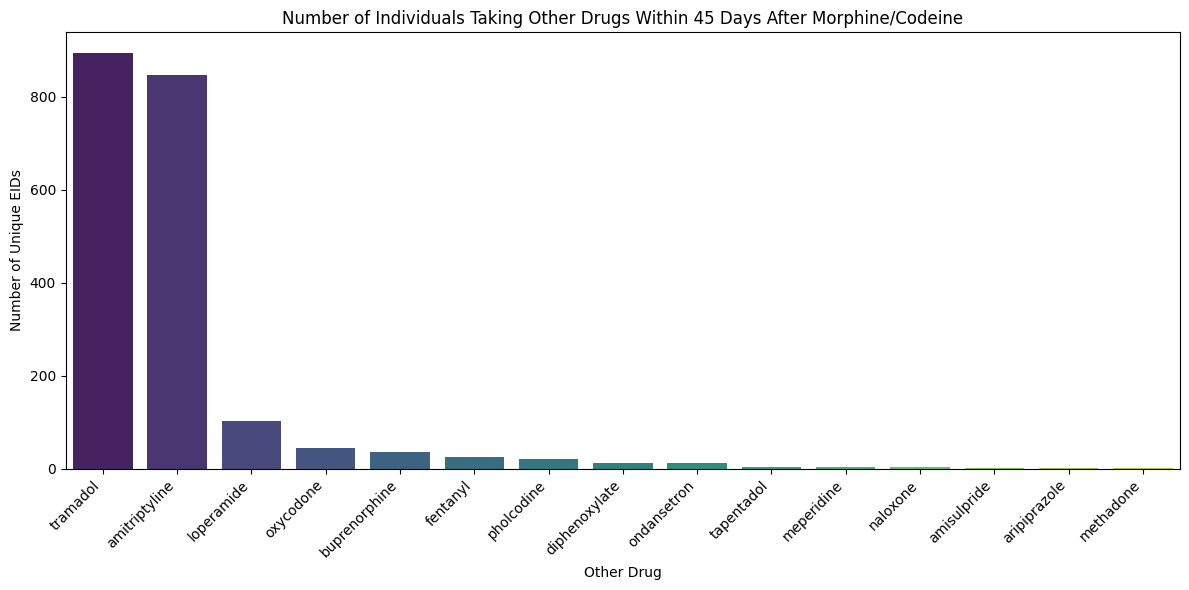

In [ ]:
# Create a new DataFrame to explode the list of drugs for 45-day window
exploded_45 = other_drugs_df[["eid", "list_other_drugs_45_days"]].explode(
    "list_other_drugs_45_days"
)

# Drop any rows where the list is empty (in case there are any)
exploded_45 = exploded_45.dropna(subset=["list_other_drugs_45_days"])

# Rename column for clarity
exploded_45 = exploded_45.rename(columns={"list_other_drugs_45_days": "other_drug"})

# Count unique eids per other drug
drug_counts = (
    exploded_45.groupby("other_drug")["eid"].nunique().reset_index(name="num_eids")
)

# Sort by count
drug_counts = drug_counts.sort_values(by="num_eids", ascending=False)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(data=drug_counts, x="other_drug", y="num_eids", palette="viridis")

plt.title(
    "Number of Individuals Taking Other Drugs Within 45 Days After Morphine/Codeine"
)
plt.xlabel("Other Drug")
plt.ylabel("Number of Unique EIDs")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
# Merge the two DataFrames based on "eid"
single_exposure_df = single_exposure_df.merge(
    other_drugs_df[
        [
            "eid",
            "num_other_drugs_45_days",
            "num_other_drugs_90_days",
            "num_other_drugs_180_days",
            "num_other_drugs_365_days",
        ]
    ],
    on="eid",
    how="left",  # Use left join to retain all rows from filtered_df_era_morphine_codeine_grouped
)

In [19]:
display(single_exposure_df.drop("eid", axis=1))

,num_drug_era_id,drugs,start_dates,end_dates,exposure_counts,gap_days,total_exposure_counts,num_other_drugs_45_days,num_other_drugs_90_days,num_other_drugs_180_days,num_other_drugs_365_days
0,1,[codeine],[2004-12-20],[2004-12-28],[1],[0],1,0,0,0,0
1,1,[morphine],[2013-02-06],[2013-03-12],[2],[0],2,1,1,1,1
2,1,[codeine],[2017-02-17],[2017-04-04],[2],[0],2,0,0,0,0
3,1,[codeine],[2007-05-30],[2007-06-24],[1],[0],1,0,0,0,0
4,1,[codeine],[2001-04-09],[2001-05-08],[1],[0],1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
40056,1,[codeine],[2004-12-31],[2005-01-14],[1],[0],1,0,0,0,0
40057,1,[codeine],[2006-10-17],[2006-11-15],[1],[0],1,0,0,0,0
40058,1,[codeine],[2014-03-05],[2014-04-03],[1],[0],1,0,0,0,0
40059,1,[codeine],[2012-05-25],[2012-06-23],[1],[0],1,0,0,0,0


Now lets create the binary phenotypes and control for further analysis

In [ ]:
# Group 1: >=1 other drugs within 45 days
group_1 = single_exposure_df[single_exposure_df["num_other_drugs_45_days"] >= 1][
    "eid"
].unique()

# Group 2: >=2 other drugs within 90 days
group_2 = single_exposure_df[single_exposure_df["num_other_drugs_90_days"] >= 2][
    "eid"
].unique()

# Group 3: >=3 other drugs within 180 days
group_3 = single_exposure_df[single_exposure_df["num_other_drugs_180_days"] >= 3][
    "eid"
].unique()

# Group 4: >=4 other drugs within 365 days
group_4 = single_exposure_df[single_exposure_df["num_other_drugs_365_days"] >= 4][
    "eid"
].unique()

# Combine all groups into one, keeping unique EIDs
group_5 = set(group_1) | set(group_2) | set(group_3) | set(group_4)

# Control Group: exactly 0 other drugs within 365 days
control_group = single_exposure_df[single_exposure_df["num_other_drugs_365_days"] == 0][
    "eid"
].unique()

In [21]:
print("Group 1 (>=1 in 45 days): n =", len(group_1))
print("Group 2 (>=2 in 90 days): n =", len(group_2))
print("Group 3 (>=3 in 180 days): n =", len(group_3))
print("Group 4 (>=4 in 365 days): n =", len(group_4))
print(f"Group 5 (union of groups 1–4) - unique EIDs: n = {len(group_5)}")
print("Control Group (0 in 365 days): n =", len(control_group))

Group 1 (>=1 in 45 days): n = 1849
Group 2 (>=2 in 90 days): n = 374
Group 3 (>=3 in 180 days): n = 239
Group 4 (>=4 in 365 days): n = 386
Group 5 (union of groups 1–4) - unique EIDs: n = 2038
Control Group (0 in 365 days): n = 36075


##### DataFrame formatting

In [43]:
participant = dataset["participant"]
df_participant = participant.retrieve_fields(names=["eid"], engine=dxdata.connect())
# Convert the Spark DataFrame 'participant' to a Pandas DataFrame
participant_df = df_participant.select("eid").toPandas()

/opt/conda/lib/python3.11/site-packages/thrift/transport/TSSLSocket.py:53: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated
  self._context = ssl.SSLContext(ssl_version)


In [ ]:
# 1. Create phenotype columns initialized to None
participant_df["group_1_45d"] = None
participant_df["group_2_90d"] = None
participant_df["group_3_180d"] = None
participant_df["group_4_365d"] = None
participant_df["group_5_any"] = None

# 2. Ensure all 'eid' lists are integers
participant_df["eid"] = participant_df["eid"].astype(int)
group_1 = [int(eid) for eid in group_1]
group_2 = [int(eid) for eid in group_2]
group_3 = [int(eid) for eid in group_3]
group_4 = [int(eid) for eid in group_4]
group_5 = [int(eid) for eid in group_5]
control_group = [int(eid) for eid in control_group]

# 3. Set all group phenotype columns to 0 for control group eids
participant_df.loc[
    participant_df["eid"].isin(control_group),
    ["group_1_45d", "group_2_90d", "group_3_180d", "group_4_365d", "group_5_any"],
] = 0

# 4. Assign 1 for participants in each group
participant_df.loc[participant_df["eid"].isin(group_1), "group_1_45d"] = 1
participant_df.loc[participant_df["eid"].isin(group_2), "group_2_90d"] = 1
participant_df.loc[participant_df["eid"].isin(group_3), "group_3_180d"] = 1
participant_df.loc[participant_df["eid"].isin(group_4), "group_4_365d"] = 1
participant_df.loc[participant_df["eid"].isin(group_5), "group_5_any"] = 1

In [ ]:
# Count the number of 1's in each phenotype column
phenotype_counts = participant_df[
    ["group_1_45d", "group_2_90d", "group_3_180d", "group_4_365d", "group_5_any"]
].sum()

# Display the result
print(phenotype_counts)

group_1_45d     1849
group_2_90d      374
group_3_180d     239
group_4_365d     386
group_5_any     2038
dtype: object


In [46]:
display(participant_df.drop("eid", axis=1))

,group_1_45d,group_2_90d,group_3_180d,group_4_365d,group_5_any
0,None,None,None,None,None
1,None,None,None,None,None
2,0,0,0,0,0
3,None,None,None,None,None
4,None,None,None,None,None
...,...,...,...,...,...
502231,None,None,None,None,None
502232,0,0,0,0,0
502233,None,None,None,None,None
502234,None,None,None,None,None


In [ ]:
# Set the 'eid' column as the index
participant_df.set_index("eid", inplace=True)

# Insert 'FID' and 'IID' as the first two columns using the index
participant_df.insert(0, "FID", participant_df.index)
participant_df.insert(1, "IID", participant_df.index)

In [ ]:
# Save the result as a TSV file
participant_df.to_csv("phenotypes.BT.tsv", sep="\t", index=False, na_rep="NA")

In [93]:
! dx upload phenotypes.BT.tsv --path /WGS_Lucia/Data/phenotypes/

[===========================================================>] Uploaded 15,384,125 of 15,384,125 bytes (100%) phenotypes.BT.tsv
ID                                file-J01jQvQJb4J4xBF9Yp299Q7p
Class                             file
Project                           project-GfVK998Jb4JJgVBjKXPyxJ9q
Folder                            /WGS_Lucia/Data/phenotypes
Name                              phenotypes.BT.tsv
State                             closing
Visibility                        visible
Types                             -
Properties                        -
Tags                              -
Outgoing links                    -
Created                           Sat Apr 19 11:26:42 2025
Created by                        luciass6
 via the job                      job-J01f6GjJb4JK8bKFq6ZPjgX3
Last modified                     Sat Apr 19 11:26:43 2025
Media type                        
archivalState                     "live"
cloudAccount                      "cloudaccount-dnanexus"


## Count the eids per mask 

In [28]:
!dx download "500k WGS:/WGS_Lucia/WGS_QC/Output/mask_morphine_eid_df.tsv"

Error: path "/opt/notebooks/mask_morphine_eid_df.tsv" already exists but
-f/--overwrite was not set


In [ ]:
# Step 1: Read the mask EID table
mask_eid_df = pd.read_csv("mask_morphine_eid_df.tsv", sep="\t")

# Convert the string list to a real list
mask_eid_df["EIDs"] = mask_eid_df["EIDs"].apply(ast.literal_eval)

# Step 2: Prepare phenotype (group) EID sets
group_columns = [
    "group_1_45d",
    "group_2_90d",
    "group_3_180d",
    "group_4_365d",
    "group_5_any",
]

participant_df["FID"] = participant_df["FID"].astype(str)

# Create case groups (group == 1)
phenotype_eids = {}
for group_col in group_columns:
    phenotype_eids[group_col] = set(
        participant_df[participant_df[group_col] == 1]["FID"].tolist()
    )

# Create a single control group:
# Must have 0 in all columns, and NO missing (NaN) values
control_mask = (
    (participant_df[group_columns].notna().all(axis=1))  # No missing values
    & (participant_df[group_columns].sum(axis=1) == 0)  # Sum == 0 means all are 0
)

control_eids = participant_df[control_mask]["FID"].tolist()
phenotype_eids["control"] = set(control_eids)

# Step 3: Create result table
result_rows = []

for _, row in mask_eid_df.iterrows():
    mask = row["Mask"]
    mask_eids = set(row["EIDs"])  # Set for fast lookup

    for pheno_name, pheno_eids in phenotype_eids.items():
        overlap = mask_eids.intersection(pheno_eids)
        result_rows.append(
            {
                "Mask": mask,
                "Phenotype_Event": pheno_name,
                "Overlap_EID_Count": len(overlap),
            }
        )

# Step 4: Create final DataFrame
mask_phenotype_overlap_df = pd.DataFrame(result_rows)

# Step 5: Add total counts
total_counts = []
for pheno_name, pheno_eids in phenotype_eids.items():
    total_counts.append(
        {
            "Mask": "Total",
            "Phenotype_Event": pheno_name,
            "Overlap_EID_Count": len(pheno_eids),
        }
    )

# Concatenate
mask_phenotype_overlap_df = pd.concat(
    [mask_phenotype_overlap_df, pd.DataFrame(total_counts)], ignore_index=True
)

# Preview
display(mask_phenotype_overlap_df)

,Mask,Phenotype_Event,Overlap_EID_Count
0,No_efficacy,group_1_45d,9
1,No_efficacy,group_2_90d,2
2,No_efficacy,group_3_180d,1
3,No_efficacy,group_4_365d,2
4,No_efficacy,group_5_any,11
5,No_efficacy,control,159
6,WT_efficacy,group_1_45d,65
7,WT_efficacy,group_2_90d,11
8,WT_efficacy,group_3_180d,5
9,WT_efficacy,group_4_365d,9


In [49]:
mask_phenotype_overlap_df.to_csv("mask_phenotype_BT_overlap.tsv", sep="\t", index=False)

In [50]:
# Upload DataFrame
!dx upload mask_phenotype_BT_overlap.tsv --path WGS_Lucia/Data/Output_regenie/BT/morphine_codeine/burden_test/

[===========================================================>] Uploaded 1,118 of 1,118 bytes (100%) mask_phenotype_BT_overlap.tsv
ID                                file-J06PXq0Jb4J0zq894Yqp1Y2G
Class                             file
Project                           project-GfVK998Jb4JJgVBjKXPyxJ9q
Folder                            /WGS_Lucia/Data/Output_regenie/BT/morphine_codeine/burden_test
Name                              mask_phenotype_BT_overlap.tsv
State                             closing
Visibility                        visible
Types                             -
Properties                        -
Tags                              -
Outgoing links                    -
Created                           Sat Apr 26 15:19:08 2025
Created by                        luciass6
 via the job                      job-J06K0vQJb4JKGG8bF2XX2fqj
Last modified                     Sat Apr 26 15:19:09 2025
Media type                        
archivalState                     "live"
cloudAccoun